In [9]:
import pandas as pd
from ydata_profiling import ProfileReport

In [10]:
df = pd.read_json("./data/formatted-data.json")
df.sample(5)

,ticker,target_from,target_to,company,action,brokerage,rating_from,rating_to,time
2293,MERC,3.0,2.0,Mercer International,target lowered by,,Sector Perform,Sector Perform,2025-11-11T00:30:07.068652191Z
2451,AYI,312.0,356.0,Acuity,target raised by,,Neutral,Neutral,2025-10-03T00:30:06.14897969Z
2124,HXL,67.0,77.0,Hexcel,target raised by,,Market Perform,Market Perform,2025-10-25T00:30:05.825760172Z
268,BOH,66.0,68.0,Bank of Hawaii,target raised by,,Underweight,Underweight,2025-10-29T00:30:05.038627062Z
2289,PL,11.0,17.0,Planet Labs PBC,target raised by,,Outperform,Outperform,2025-10-03T00:30:06.512968088Z


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2670 entries, 0 to 2669
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       2670 non-null   object 
 1   target_from  2670 non-null   float64
 2   target_to    2670 non-null   float64
 3   company      2670 non-null   object 
 4   action       2670 non-null   object 
 5   brokerage    2670 non-null   object 
 6   rating_from  2670 non-null   object 
 7   rating_to    2670 non-null   object 
 8   time         2670 non-null   object 
dtypes: float64(2), object(7)
memory usage: 187.9+ KB


In [12]:
# Extract unique values and their frequencies

# Company - Top 5 only
print("=" * 50)
print("COMPANY - Top 5")
print("=" * 50)
print(df['company'].value_counts().head(5))
print()

# Action - All unique values
print("=" * 50)
print("ACTION")
print("=" * 50)
print(df['action'].value_counts())
print()

# Brokerage - All unique values
print("=" * 50)
print("BROKERAGE")
print("=" * 50)
print(df['brokerage'].value_counts().head(10))
print()

# Rating From - All unique values
print("=" * 50)
print("RATING FROM")
print("=" * 50)
print(df['rating_from'].value_counts())
print()

# Rating To - All unique values
print("=" * 50)
print("RATING TO")
print("=" * 50)
print(df['rating_to'].value_counts())


COMPANY - Top 5
company
Alphabet            2
Blue Owl Capital    2
Zillow Group        2
Berry               1
Redwood Trust       1
Name: count, dtype: int64

ACTION
action
target raised by     1262
target lowered by     815
reiterated by         272
initiated by          173
target set by          66
upgraded by            50
downgraded by          32
Name: count, dtype: int64

BROKERAGE
brokerage
                         2289
HC Wainwright              56
UBS Group                  28
JPMorgan Chase & Co.       20
Bank of America            18
Morgan Stanley             13
Royal Bank Of Canada       11
Barrington Research        11
Piper Sandler              10
Wells Fargo & Company      10
Name: count, dtype: int64

RATING FROM
rating_from
Buy                    795
Neutral                452
Overweight             336
Outperform             316
Equal Weight           197
Hold                   133
Underweight             81
Market Perform          80
Sector Perform          68
  

In [13]:
profile = ProfileReport(df)
report = profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# ML model

In [14]:
import numpy as np
from sklearn.cluster import KMeans
import json

In [15]:
# Add new features to the dataframe

# 1. target_delta as percentage
df['target_delta'] = ((df['target_to'] - df['target_from']) / df['target_from'] * 100).round(1)

# 2. has_brokerage - binary indicator (1 if not empty, 0 if empty)
df['has_brokerage'] = (df['brokerage'].str.strip() != '').astype(int)

# 3. Convert time from ISO string to datetime with timezone
df['time'] = pd.to_datetime(df['time'], utc=True)

# 4. time_delta - number of days from time to today
today = pd.Timestamp.now(tz='UTC')
df['time_delta'] = (today - df['time']).dt.days

# Display sample to verify changes
print("Sample of new features:")
df[['time', 'time_delta', 'target_delta', 'has_brokerage']].sample(3)


Sample of new features:


,time,time_delta,target_delta,has_brokerage
551,2025-08-17 00:30:05.023721436+00:00,88,0.0,1
756,2025-08-25 00:30:05.055310938+00:00,80,7.7,1
1976,2025-11-07 00:30:06.812121820+00:00,6,-30.0,0


In [16]:
# Normalize action, rating_from, and rating_to by converting to lowercase
df['action'] = df['action'].str.lower()
df['rating_from'] = df['rating_from'].str.lower()
df['rating_to'] = df['rating_to'].str.lower()


In [17]:
# Get unique values for action, rating_from, and rating_to

print("UNIQUE VALUES IN ACTION:")
print(df['action'].unique())
print(f"Total: {df['action'].nunique()} unique values\n")

print("UNIQUE VALUES IN RATING_FROM:")
print(df['rating_from'].unique())
print(f"Total: {df['rating_from'].nunique()} unique values\n")

print("UNIQUE VALUES IN RATING_TO:")
print(df['rating_to'].unique())
print(f"Total: {df['rating_to'].nunique()} unique values")


UNIQUE VALUES IN ACTION:
['target lowered by' 'target raised by' 'reiterated by' 'upgraded by'
 'initiated by' 'target set by' 'downgraded by']
Total: 7 unique values

UNIQUE VALUES IN RATING_FROM:
['buy' 'neutral' 'market perform' 'in-line' 'outperform' 'equal weight'
 'overweight' 'sector outperform' 'sector perform' 'underweight' 'hold'
 'underperform' '' 'sell' 'market outperform' 'positive' 'speculative buy'
 'strong-buy' 'sector underperform' 'sector weight' 'peer perform'
 'negative' 'outperformer']
Total: 23 unique values

UNIQUE VALUES IN RATING_TO:
['buy' 'neutral' 'market perform' 'in-line' 'outperform' 'equal weight'
 'overweight' 'sector outperform' 'sector perform' 'underweight'
 'underperform' '' 'hold' 'sell' 'market outperform' 'positive'
 'speculative buy' 'sector performer' 'strong-buy' 'reduce' 'negative']
Total: 21 unique values


In [18]:
# Create dictionaries to map categorical values to numeric scores (-1 to 1)

# Action mapping (upgrade/downgrade/maintained/initiated)
action_mapping = {
    'upgrades': 1,
    'upgraded by': 1,
    'target raised by': 1,
    'downgrades': -1,
    'downgraded by': -1,
    'target lowered by': -1,
    'maintains': 0,
    'initiates coverage on': 0,
    'initiates': 0,
    'initiated by': 0,
    'reiterates': 0,
    'reiterated by': 0,
    'target set by': 0,
    '': 0
}

# Rating mapping (based on investment recommendation strength)
# Score from -1 (bearish) to 1 (bullish), 0 for neutral
rating_mapping = {
    # Most bullish (1.0)
    'strong-buy': 1.0,
    'strong buy': 1.0,
    
    # Very bullish (0.75-0.9)
    'buy': 0.75,
    'speculative buy': 0.75,
    'outperform': 0.75,
    'outperformer': 0.75,
    'overweight': 0.75,
    'accumulate': 0.75,
    'market outperform': 0.75,
    'sector outperform': 0.75,
    
    # Slightly bullish (0.25-0.5)
    'positive': 0.5,
    
    # Neutral (0)
    'hold': 0,
    'neutral': 0,
    'market perform': 0,
    'equal weight': 0,
    'equal-weight': 0,
    'in-line': 0,
    'sector perform': 0,
    'sector performer': 0,
    'sector weight': 0,
    'peer perform': 0,
    
    # Slightly bearish (-0.25 to -0.5)
    'negative': -0.5,
    
    # Very bearish (-0.75 to -0.9)
    'underperform': -0.75,
    'underweight': -0.75,
    'reduce': -0.75,
    'sector underperform': -0.75,
    
    # Most bearish (-1.0)
    'sell': -1.0,
    'strong sell': -1.0,
    
    # Empty/missing
    '': 0
}

# Apply mappings to create numeric columns
df['action_score'] = df['action'].map(action_mapping)
df['rating_from_score'] = df['rating_from'].map(rating_mapping)
df['rating_to_score'] = df['rating_to'].map(rating_mapping)

# Create rating_delta_score (change in rating sentiment)
df['rating_delta_score'] = df['rating_to_score'] - df['rating_from_score']

print("✓ Created mappings and numeric score columns (-1 to 1):")
print(f"  - action_score: -1 (downgrade), 0 (neutral), 1 (upgrade)")
print(f"  - rating_from_score: -1 (bearish) to 1 (bullish)")
print(f"  - rating_to_score: -1 (bearish) to 1 (bullish)")
print(f"  - rating_delta_score: change from rating_from to rating_to")
print("\nSample of mapped values:")
print(df[['action', 'action_score', 'rating_from', 'rating_from_score', 'rating_to', 'rating_to_score', 'rating_delta_score']].sample(5))


✓ Created mappings and numeric score columns (-1 to 1):
  - action_score: -1 (downgrade), 0 (neutral), 1 (upgrade)
  - rating_from_score: -1 (bearish) to 1 (bullish)
  - rating_to_score: -1 (bearish) to 1 (bullish)
  - rating_delta_score: change from rating_from to rating_to

Sample of mapped values:
                 action  action_score     rating_from  rating_from_score  \
481       reiterated by             0             buy               0.75   
1663  target lowered by            -1                               0.00   
913    target raised by             1  market perform               0.00   
2661   target raised by             1    equal weight               0.00   
146    target raised by             1  sector perform               0.00   

           rating_to  rating_to_score  rating_delta_score  
481              buy             0.75                 0.0  
1663                             0.00                 0.0  
913   market perform             0.00                 0.0  
2

In [19]:
# Check for NaN or null values in the new columns
print("\n" + "=" * 50)
print("CHECKING FOR NULL/NAN VALUES IN NEW COLUMNS")
print("=" * 50)
new_columns = ['target_delta', 'has_brokerage', 'action_score', 'rating_from_score', 'rating_to_score', 'rating_delta_score', 'time_delta']
for col in new_columns:
    null_count = df[col].isna().sum()
    total_count = len(df)
    if null_count > 0:
        print(f"⚠️  {col}: {null_count}/{total_count} null values ({null_count/total_count*100:.2f}%)")
    else:
        print(f"✓  {col}: No null values")



CHECKING FOR NULL/NAN VALUES IN NEW COLUMNS
✓  target_delta: No null values
✓  has_brokerage: No null values
✓  action_score: No null values
✓  rating_from_score: No null values
✓  rating_to_score: No null values
✓  rating_delta_score: No null values
✓  time_delta: No null values


In [20]:
df.sample(3)

,ticker,target_from,target_to,company,action,brokerage,rating_from,rating_to,time,target_delta,has_brokerage,time_delta,action_score,rating_from_score,rating_to_score,rating_delta_score
280,SYRE,43.0,43.0,Spyre Therapeutics,initiated by,,buy,buy,2025-09-28 00:30:11.407411113+00:00,0.0,0,46,0,0.75,0.75,0.0
1219,PATH,12.5,13.0,UiPath,target raised by,,market perform,market perform,2025-10-03 00:30:06.248631908+00:00,4.0,0,41,1,0.00,0.00,0.0
604,WKSP,11.5,11.5,Worksport,reiterated by,,buy,buy,2025-09-30 00:30:08.660561872+00:00,0.0,0,44,0,0.75,0.75,0.0


In [21]:
# Prepare features for clustering
feature_columns = [
    'target_delta',
    'has_brokerage',
    'action_score',
    'rating_delta_score',  # Using rating delta instead of from/to
    'time_delta'
]

# Create feature matrix (drop any rows with NaN values)
X = df[feature_columns].dropna()
print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {feature_columns}")
print("\nFeature statistics:")
print(X.describe())


Feature matrix shape: (2670, 5)
Features used: ['target_delta', 'has_brokerage', 'action_score', 'rating_delta_score', 'time_delta']

Feature statistics:
       target_delta  has_brokerage  action_score  rating_delta_score  \
count   2670.000000    2670.000000   2670.000000         2670.000000   
mean       4.759551       0.142697      0.174157           -0.004401   
std       28.969913       0.349829      0.882369            0.172463   
min      -82.400000       0.000000     -1.000000           -1.750000   
25%       -4.300000       0.000000     -1.000000            0.000000   
50%        0.000000       0.000000      0.000000            0.000000   
75%        9.675000       0.000000      1.000000            0.000000   
max      733.300000       1.000000      1.000000            1.750000   

        time_delta  
count  2670.000000  
mean     30.015356  
std      28.128395  
min       2.000000  
25%       7.000000  
50%      15.000000  
75%      51.000000  
max      91.000000  


In [22]:
# Standardize the features (important for K-means)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Features standardized")
print(f"Scaled feature matrix shape: {X_scaled.shape}")


✓ Features standardized
Scaled feature matrix shape: (2670, 5)


In [23]:
# Determine optimal number of clusters using elbow method
from sklearn.metrics import silhouette_score

inertias = []
silhouette_scores = []
K_range = range(2, 20)

print("Finding optimal number of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_scores[-1]:.3f}")


Finding optimal number of clusters...
K=2: Inertia=9214.97, Silhouette Score=0.529
K=3: Inertia=6533.96, Silhouette Score=0.499
K=4: Inertia=5437.66, Silhouette Score=0.525
K=5: Inertia=4165.41, Silhouette Score=0.558
K=6: Inertia=3329.36, Silhouette Score=0.595
K=7: Inertia=2381.62, Silhouette Score=0.599
K=8: Inertia=1951.08, Silhouette Score=0.624
K=9: Inertia=1699.35, Silhouette Score=0.621
K=10: Inertia=1535.52, Silhouette Score=0.624
K=11: Inertia=1339.33, Silhouette Score=0.614
K=12: Inertia=1222.46, Silhouette Score=0.618
K=13: Inertia=1108.58, Silhouette Score=0.623
K=14: Inertia=1003.98, Silhouette Score=0.617
K=15: Inertia=921.12, Silhouette Score=0.630
K=16: Inertia=844.09, Silhouette Score=0.616
K=17: Inertia=771.97, Silhouette Score=0.616
K=18: Inertia=706.48, Silhouette Score=0.601
K=19: Inertia=672.13, Silhouette Score=0.627


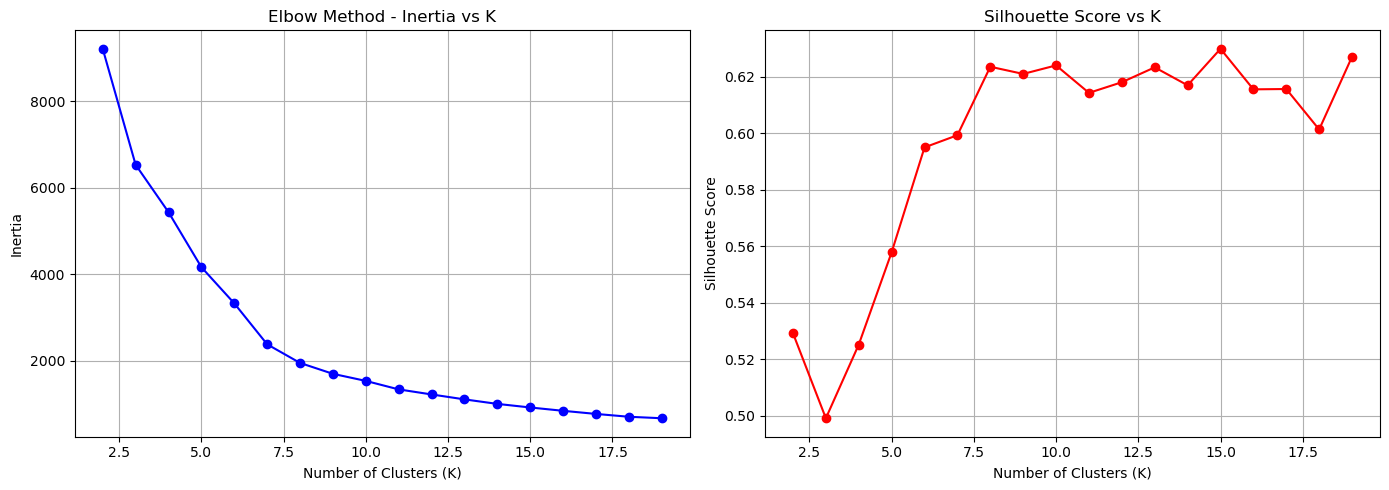

In [24]:
# Visualize elbow method and silhouette scores

import matplotlib.pyplot as plt
%matplotlib inline


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method - Inertia vs K')
ax1.grid(True)

# Silhouette score plot
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs K')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Fit final K-means model with optimal K (let's use K=4 as a starting point)
optimal_k = 8

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe (only for rows without NaN)
df_clustered = df.loc[X.index].copy()
df_clustered['cluster'] = cluster_labels

print(f"✓ K-means clustering completed with K={optimal_k}")
print(f"\nCluster distribution:")
print(df_clustered['cluster'].value_counts().sort_index())
print(f"\nCluster centers (standardized):")
print(feature_columns)
print(kmeans_final.cluster_centers_)


✓ K-means clustering completed with K=8

Cluster distribution:
cluster
0    887
1    715
2    337
3     69
4     55
5    514
6      3
7     90
Name: count, dtype: int64

Cluster centers (standardized):
['target_delta', 'has_brokerage', 'action_score', 'rating_delta_score', 'time_delta']
[[ 0.22332595 -0.40798067  0.93611333  0.02552177 -0.73988626]
 [-0.58744128 -0.40798067 -1.33093664  0.02552177 -0.64078758]
 [-0.11812978  2.45109649 -0.06286863  0.02552177  1.80298987]
 [-0.484706    0.66935275 -0.7395323  -4.53416378  1.19296343]
 [ 0.48280109  0.42375087  0.79184652  4.48052749  1.03451282]
 [-0.0378035  -0.40798067  0.12897297  0.0283425   0.74250391]
 [18.21910803 -0.40798067  0.93611333  0.02552177 -0.62873601]
 [ 2.5933829  -0.34444563  0.89832917  0.02552177 -0.13487596]]


In [26]:
# Analyze cluster characteristics
print("=" * 80)
print("CLUSTER CHARACTERISTICS")
print("=" * 80)

for cluster_id in range(optimal_k):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data)})")
    print(f"{'='*80}")
    
    # Feature means
    print("\nFeature Averages:")
    for col in feature_columns:
        mean_val = cluster_data[col].mean()
        print(f"  {col}: {mean_val:.2f}")
    
    # Most common actions
    print("\nTop Actions:")
    print(cluster_data['action'].value_counts().head(3))
    
    # Most common companies
    print("\nTop Companies:")
    print(cluster_data['company'].value_counts().head(5))


CLUSTER CHARACTERISTICS

CLUSTER 0 (n=887)

Feature Averages:
  target_delta: 11.23
  has_brokerage: 0.00
  action_score: 1.00
  rating_delta_score: 0.00
  time_delta: 9.21

Top Actions:
action
target raised by    887
Name: count, dtype: int64

Top Companies:
company
Alphabet                          2
Esquire Financial                 1
Johnson Controls International    1
Moody's                           1
Element Solutions                 1
Name: count, dtype: int64

CLUSTER 1 (n=715)

Feature Averages:
  target_delta: -12.26
  has_brokerage: 0.00
  action_score: -1.00
  rating_delta_score: 0.00
  time_delta: 11.99

Top Actions:
action
target lowered by    715
Name: count, dtype: int64

Top Companies:
company
Blue Owl Capital      2
Zillow Group          2
Textron               1
Starbucks             1
WhiteHorse Finance    1
Name: count, dtype: int64

CLUSTER 2 (n=337)

Feature Averages:
  target_delta: 1.34
  has_brokerage: 1.00
  action_score: 0.12
  rating_delta_score: 0.00
  t

In [28]:
# Export centroids to JSON
means = scaler.mean_
stds = scaler.scale_
output_data = {
    "k": optimal_k,
    "features": feature_columns,
    "centroids": kmeans_final.cluster_centers_.tolist(),
    "means": means.tolist(),
    "stds": stds.tolist()
}

# Save to JSON file
output_path = './data/centroids.json'
with open(output_path, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"✓ Centroids exported to {output_path}")
print(f"\nStructure:")
print(f"  - K clusters: {output_data['k']}")
print(f"  - Features: {output_data['features']}")
print(f"  - Centroids shape: {len(output_data['centroids'])} x {len(output_data['centroids'][0])}")
print(f"\nPreview:")
print(json.dumps(output_data, indent=2))


✓ Centroids exported to ./data/centroids.json

Structure:
  - K clusters: 8
  - Features: ['target_delta', 'has_brokerage', 'action_score', 'rating_delta_score', 'time_delta']
  - Centroids shape: 8 x 5

Preview:
{
  "k": 8,
  "features": [
    "target_delta",
    "has_brokerage",
    "action_score",
    "rating_delta_score",
    "time_delta"
  ],
  "centroids": [
    [
      0.22332595118475182,
      -0.4079806743810494,
      0.9361133317031605,
      0.025521773327968907,
      -0.739886260584197
    ],
    [
      -0.5874412768085852,
      -0.40798067438104907,
      -1.330936641673198,
      0.025521773327968872,
      -0.6407875785644097
    ],
    [
      -0.11812977649648537,
      2.4510964925412484,
      -0.06286862985882681,
      0.025521773327968844,
      1.802989871024832
    ],
    [
      -0.4847060038211103,
      0.6693527508360514,
      -0.739532300792413,
      -4.534163779706836,
      1.1929634295295881
    ],
    [
      0.4828010881551435,
      0.423750865